In [6]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import scipy 

In [7]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [8]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA

In [10]:
from kneed import KneeLocator as kl

#### Data Import

In [11]:
adata = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Tcell.h5ad")

In [12]:
adata.X = adata.layers['raw_counts']

In [13]:
adata.raw = adata

#### Normalize counts to 10.000 reads x cells

In [14]:
norm_data = adata.copy()

In [15]:
sc.pp.normalize_total(norm_data, target_sum=1e4)

In [16]:
adata.layers['norm_data'] = norm_data.X.copy()

#### log n+1 transform

In [17]:
sc.pp.log1p(norm_data)

In [18]:
adata.layers['log1p'] = norm_data.X

#### identify higly variable genes

In [19]:
adata.layers

Layers with keys: log1p, norm_data, raw_counts, regressed, scaled, scaled_regressed

In [20]:
sc.pp.highly_variable_genes(adata,layer="log1p",n_top_genes=1000)

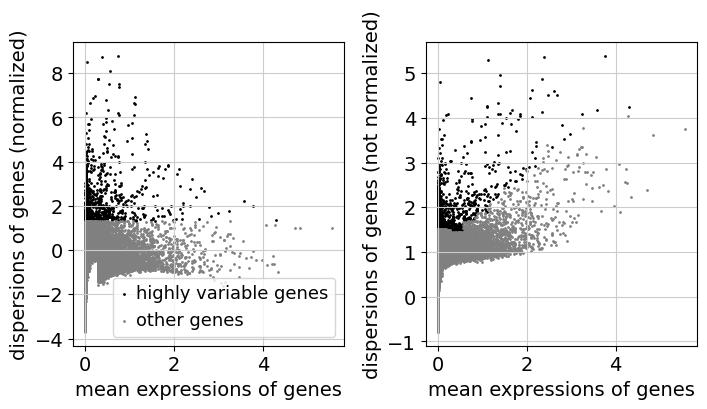

In [21]:
sc.pl.highly_variable_genes(adata)

#### Perform scaling

In [22]:
adata.layers['scaled'] = adata.layers['log1p']

In [23]:
adata.layers['scaled'] = sc.pp.scale(adata, max_value=10, layer="scaled",copy=True).layers['scaled']

#### Cell Cycle Score

In [24]:
cell_cycle_genes = [x.strip() for x in open('/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/regev_lab_cell_cycle_genes.txt')]

In [25]:
s_genes = cell_cycle_genes[:40]
g2m_genes = cell_cycle_genes[40:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [26]:
adata_cc_genes = adata.copy()

In [27]:
adata_cc_genes.raw = adata_cc_genes

In [28]:
adata_cc_genes = sc.tl.score_genes_cell_cycle(adata_cc_genes, s_genes=["Mcm5","Pcna",'Tyms','Fen1','Mcm2','Mcm4','Rrm1','Ung','Gins2','Mcm6','Cdca7','Dtl','Prim1','Uhrf1','Hells','Rfc2','Rpa2','Nasp','Rad51ap1','Gmnn','Wdr76','Slbp','Ccne2','Ubr7','Msh2','Rad51','Rrm2','Cdc45','Cdc6','Exo1','Tipin','Dscc1','Blm','Casp8ap2','Usp1','Clspn','Pola1','Chaf1b','Brip1','E2f8'],
                             g2m_genes=['Hmgb2','Nusap1','Ube2c','Birc5','Tpx2','Top2a','Ndc80','Cks2','Nuf2','Cks1b','Cks1brt','Mki67','Cenpf','Tacc3','Pimreg','Smc4','Ccnb2','Ckap2l','Ckap2','Aurkb','Bub1','Kif11','Anp32e','Tubb4b','Gtse1','Kif20b','Hjurp','Cdca3','Cdc20','Ttk','Cdc25c','Kif2c','Rangap1','Ncapd2','Dlgap5','Cdca2','Cdca8','Ect2','Kif23','Hmmr','Aurka','Psrc1','Anln','Lbr','Ckap5','Cenpe','Ctcf','Nek2','G2e3','Cenpa'],
                                              use_raw=True,copy=True)

In [29]:
adata_cc_genes.X = adata_cc_genes.layers['scaled']

In [30]:
sc.tl.pca(adata_cc_genes,svd_solver='arpack',copy=False)

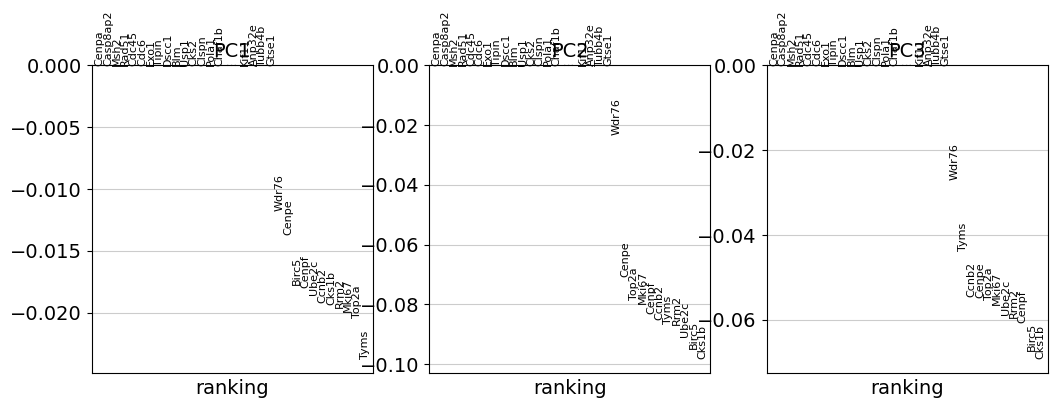

In [31]:
sc.pl.pca_loadings(adata_cc_genes[:, cell_cycle_genes])

... storing 'phase' as categorical


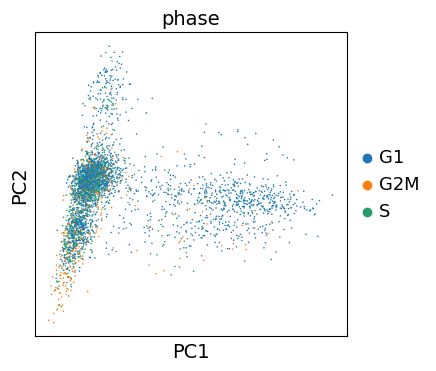

In [32]:
sc.pl.pca_scatter(adata_cc_genes, color='phase',s=5)

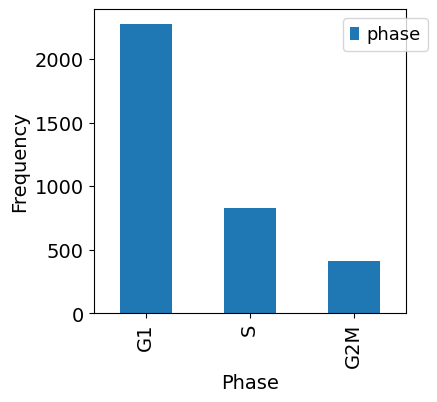

In [33]:
fig, (ax1) = plt.subplots(1,1)
ax1 = adata_cc_genes.obs["phase"].value_counts(normalize=False).plot.bar(legend=False,ax=ax1)
ax1.set_xlabel("Phase")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [34]:
print(adata_cc_genes.obs["phase"].value_counts(normalize=True))
print(adata_cc_genes.obs["phase"].value_counts(normalize=False))

G1     0.646324
S      0.235879
G2M    0.117797
Name: phase, dtype: float64
G1     2277
S       831
G2M     415
Name: phase, dtype: int64


In [35]:
adata.obs = adata_cc_genes.obs

In [36]:
adata.layers['regressed'] = sc.pp.regress_out(adata, ['S_score', 'G2M_score'],n_jobs=10,copy=True).X

In [37]:
adata.layers['scaled_regressed'] = adata.layers['regressed']

In [38]:
adata.layers['scaled_regressed'] = sc.pp.scale(adata, max_value=10, layer="scaled_regressed",copy=True,zero_center=True,).layers['scaled_regressed']

#### PCA

In [39]:
adata.X = adata.layers['scaled_regressed']

In [40]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

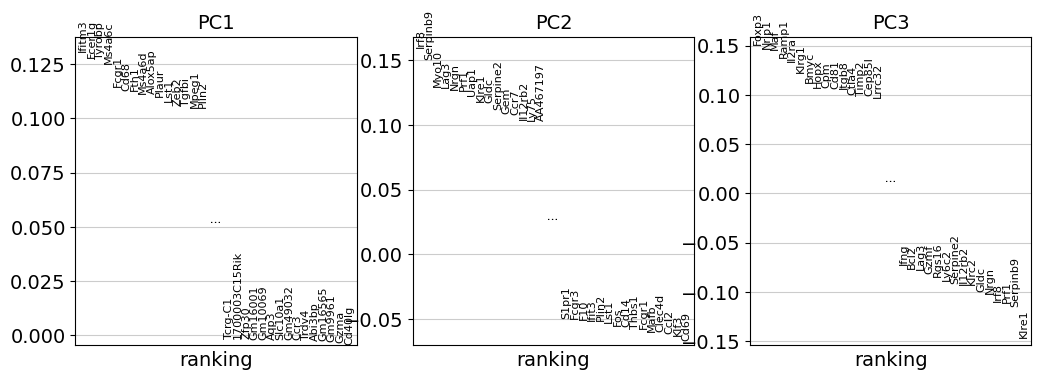

In [41]:
sc.pl.pca_loadings(adata)

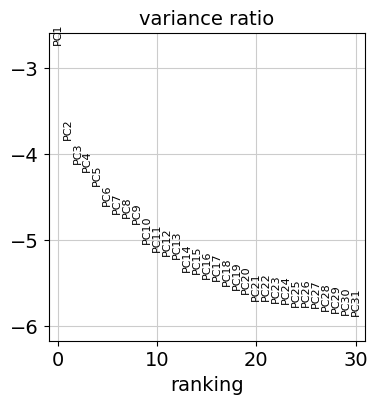

In [42]:
sc.pl.pca_variance_ratio(adata,log=True)

In [43]:
def PCA_elbox_fit(data):
    model = PCA().fit(data)
    explanied_variance = model.explained_variance_ratio_
    pcs = list(range(1,explanied_variance.shape[0]+1))
    klm = kl(pcs, explanied_variance,S=1.0, curve='convex',direction="decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1,pcs_used+1))
    new_data = PCA(n_components=pcs_used,svd_solver="arpack").fit_transform(data)
    return pcs_used, new_data,pcs, explanied_variance,pc_list

In [44]:
HVG_data = adata[:,adata.var.highly_variable]

In [45]:
label = "HVG_data"

In [46]:
new_frame = pd.DataFrame(HVG_data.X.toarray(),index=HVG_data.obs_names,columns=HVG_data.var_names)

In [47]:
pandas_data = new_frame.values

In [48]:
dim,new_matrix, pc_ax,pc_ay,col_labels = PCA_elbox_fit(pandas_data)

In [49]:
print(dim)

21


In [50]:
columns = ["PC_"+str(i) for i in col_labels]

In [51]:
outputpath = "/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/"

In [52]:
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(),columns=columns)

In [53]:
PC_frame.shape

(3523, 21)

Text(0, 0.5, 'Explained variance Ratio')

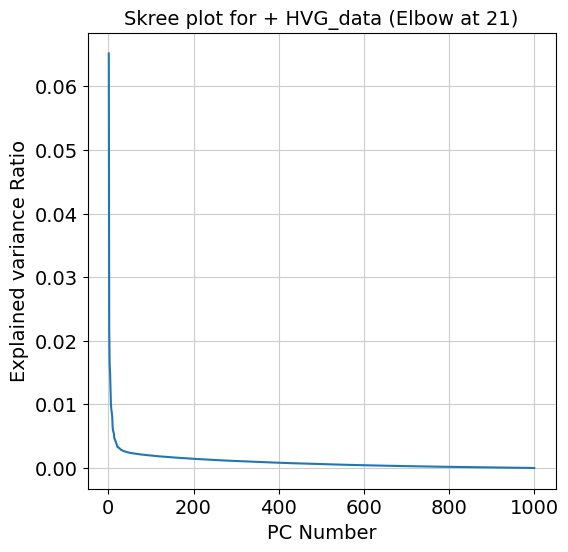

In [54]:
fig = plt.figure(figsize = (6,6,))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree plot for + "+label+" (Elbow at "+str(dim)+")")
ax1.plot(pc_ax,pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained variance Ratio")


In [55]:
adata.X.min()

-12.218442

In [56]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=dim)

In [57]:
sc.tl.umap(adata)

In [58]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

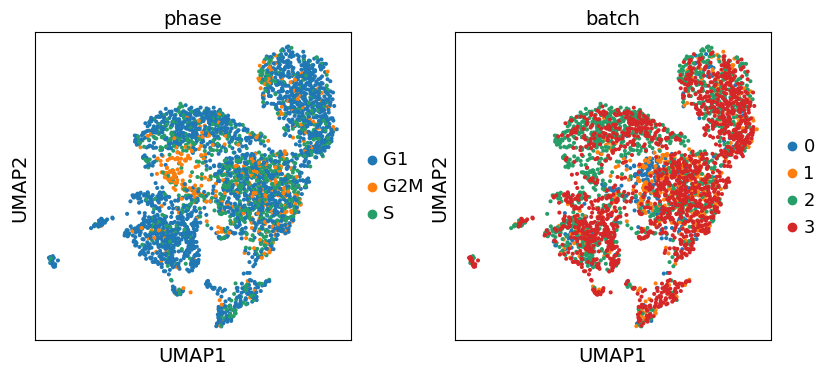

In [59]:
sc.pl.umap(adata,layer='scaled',color=['phase','batch'])

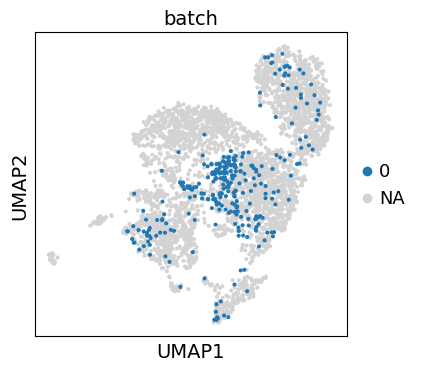

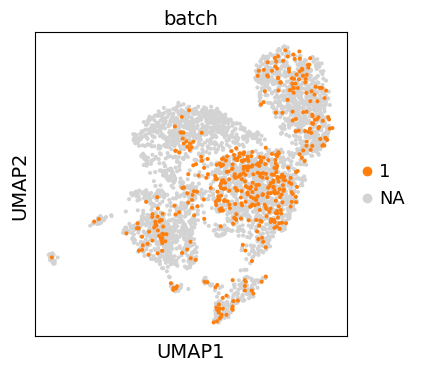

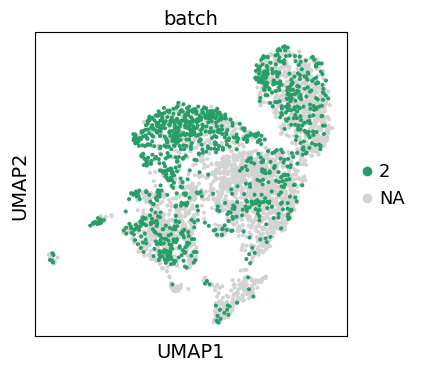

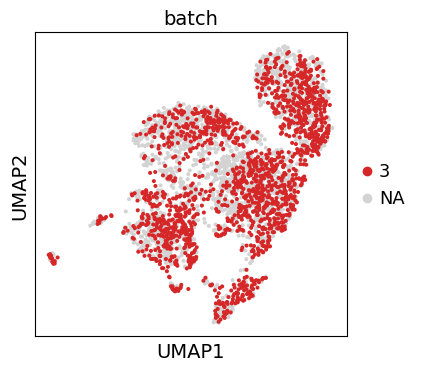

In [60]:
for batch in ['0','1', '2', '3']:
    sc.pl.umap(adata, color='batch', groups=[batch])

#### Harmony Integration

In [61]:
adata2 = adata.copy()

In [62]:
import scanpy.external as sce

In [63]:
sce.pp.harmony_integrate(adata,key='batch',epsilon_cluster = 1e-4, epsilon_harmony = 1e-5, max_iter_harmony=30)

2021-10-23 18:54:33,503 - harmonypy - INFO - Iteration 1 of 30
2021-10-23 18:54:34,507 - harmonypy - INFO - Iteration 2 of 30
2021-10-23 18:54:35,370 - harmonypy - INFO - Iteration 3 of 30
2021-10-23 18:54:35,742 - harmonypy - INFO - Iteration 4 of 30
2021-10-23 18:54:36,029 - harmonypy - INFO - Iteration 5 of 30
2021-10-23 18:54:36,326 - harmonypy - INFO - Iteration 6 of 30
2021-10-23 18:54:36,611 - harmonypy - INFO - Iteration 7 of 30
2021-10-23 18:54:36,907 - harmonypy - INFO - Iteration 8 of 30
2021-10-23 18:54:37,192 - harmonypy - INFO - Iteration 9 of 30
2021-10-23 18:54:37,489 - harmonypy - INFO - Iteration 10 of 30
2021-10-23 18:54:37,774 - harmonypy - INFO - Iteration 11 of 30
2021-10-23 18:54:38,070 - harmonypy - INFO - Iteration 12 of 30
2021-10-23 18:54:38,355 - harmonypy - INFO - Iteration 13 of 30
2021-10-23 18:54:38,652 - harmonypy - INFO - Iteration 14 of 30
2021-10-23 18:54:38,937 - harmonypy - INFO - Iteration 15 of 30
2021-10-23 18:54:39,233 - harmonypy - INFO - Conv

In [64]:
sc.pp.neighbors(adata, n_neighbors=10,use_rep='X_pca_harmony', n_pcs=dim)

In [65]:
sc.tl.umap(adata)

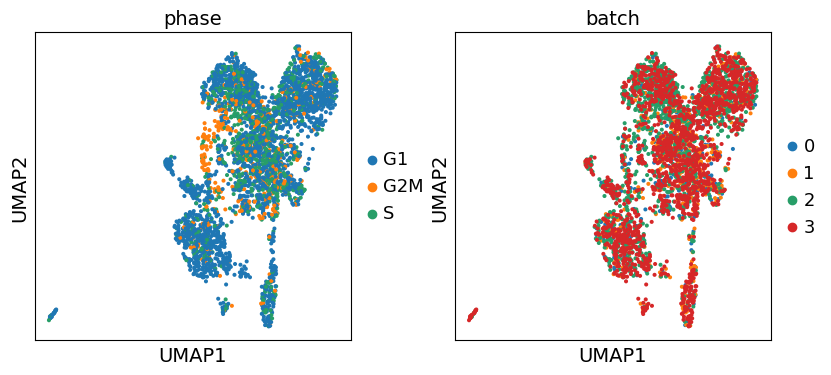

In [66]:
sc.pl.umap(adata,layer='scaled',color=['phase','batch'])

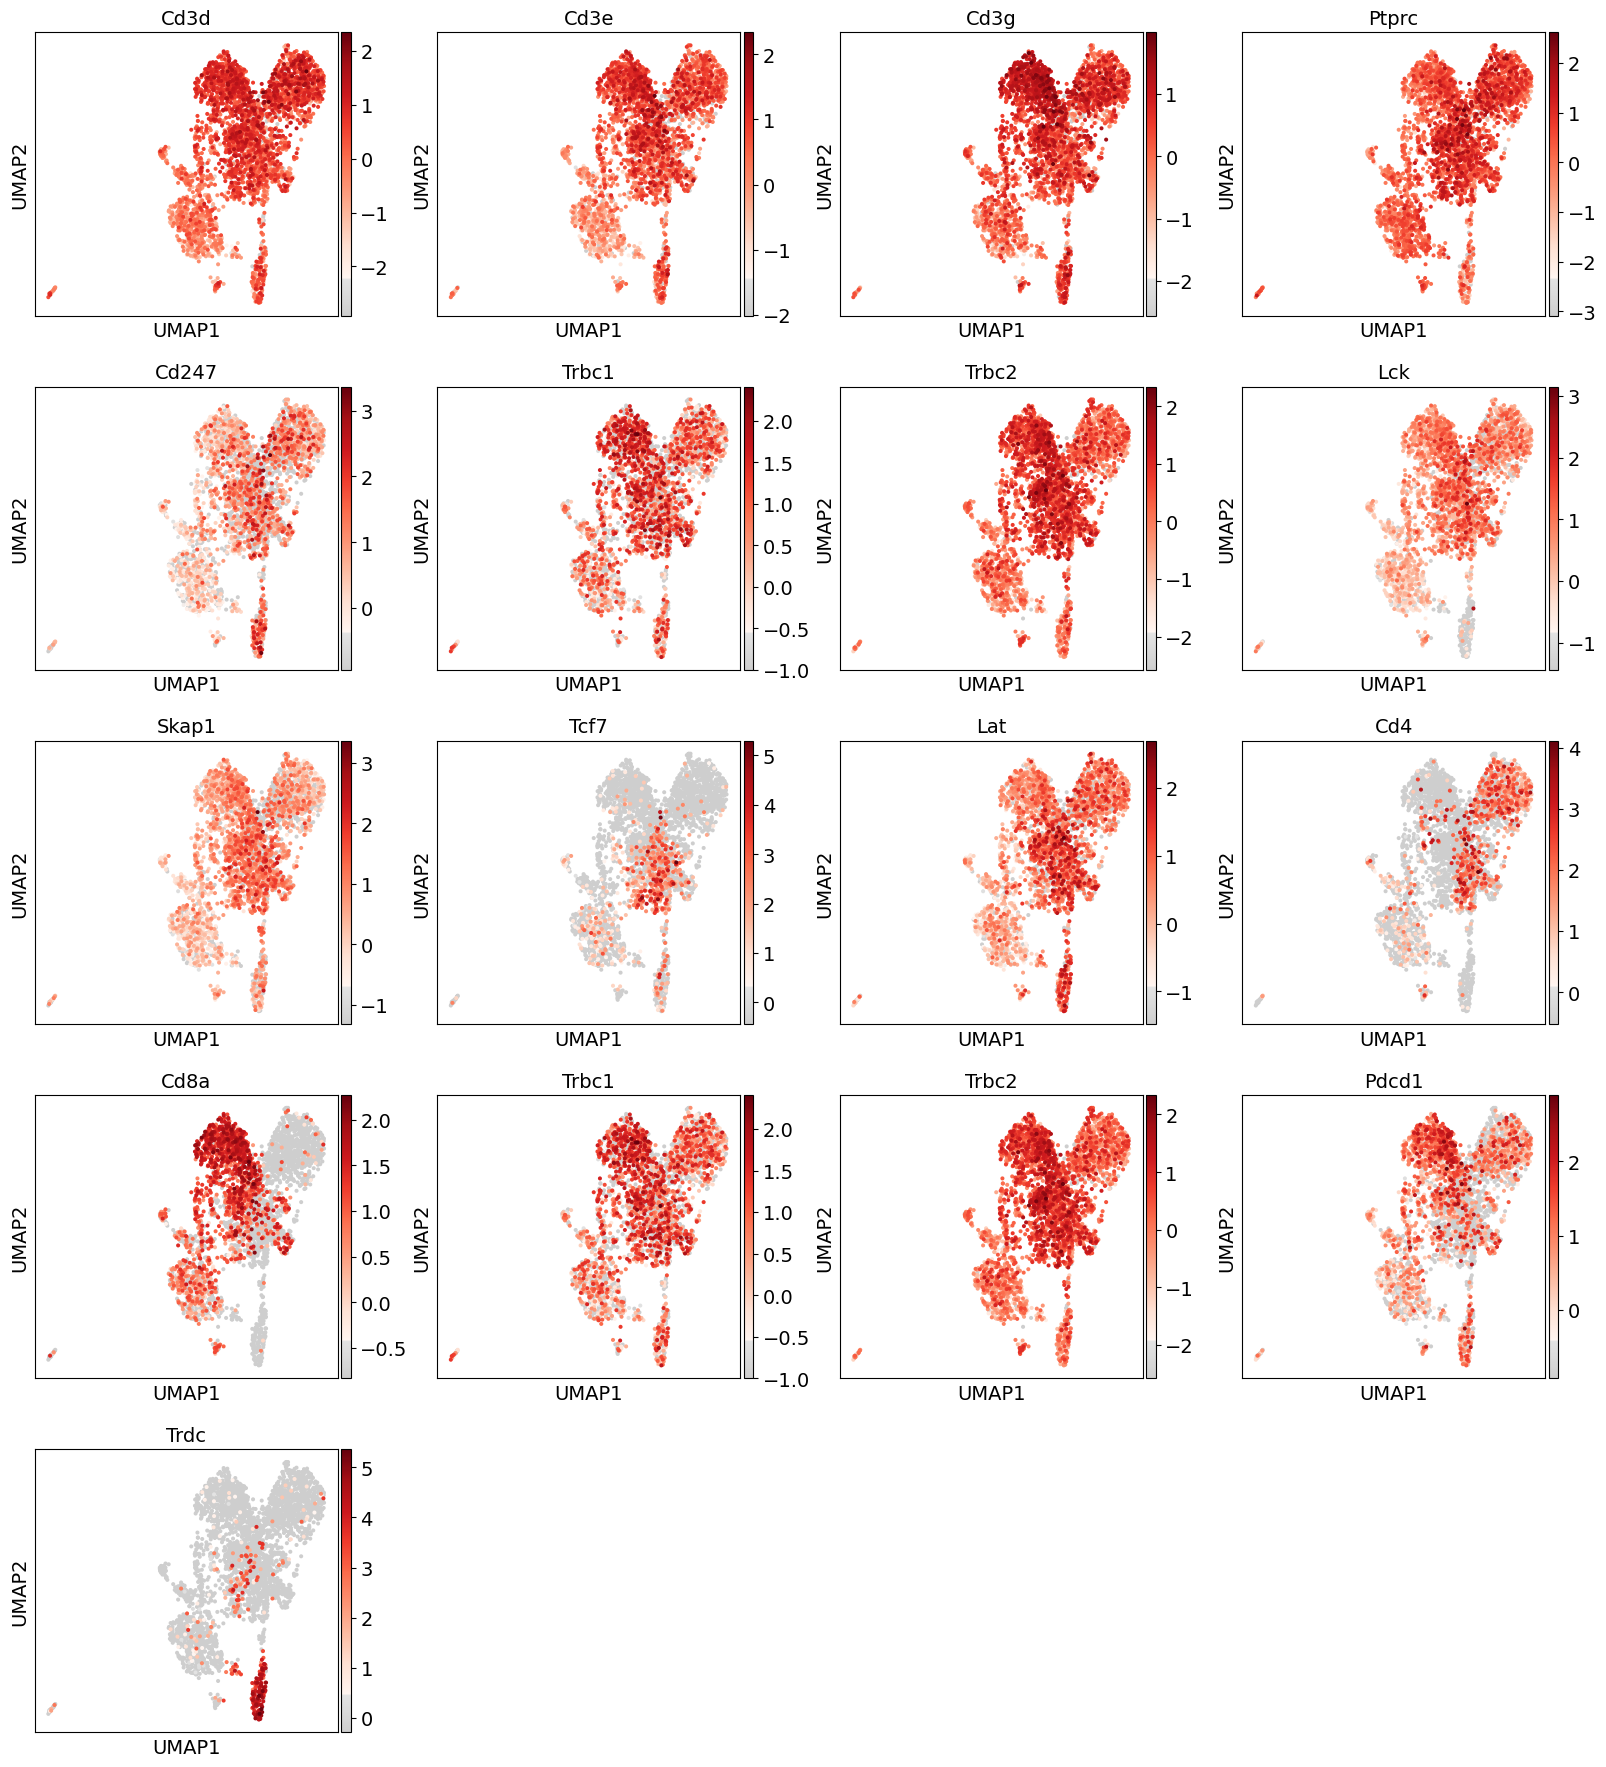

In [67]:
sc.pl.umap(adata,layer='scaled',color=['Cd3d','Cd3e','Cd3g','Ptprc','Cd247','Trbc1','Trbc2','Lck','Skap1','Tcf7','Lat','Cd4','Cd8a','Trbc1','Trbc2','Pdcd1','Trdc'],color_map=mymap)


#### DESC Integration

In [68]:
adata2.X = adata2.layers['scaled']

In [69]:
import desc
#import keras
import tensorflow as tf
from time import time                                                       
import sys

In [70]:
save_dir="/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated"
adata2=desc.train(adata2,
        dims=[adata.shape[1],64,32],
        tol=0.005,
        n_neighbors=10,
        batch_size=256,
        louvain_resolution=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2],# not necessarily a list, you can only set one value, like, louvain_resolution=1.0
        save_dir=str(save_dir),
        do_tsne=False,
        learning_rate=200, # the parameter of tsne
        use_GPU=False,
        num_Cores=30, #for reproducible, only use 1 cpu
        num_Cores_tsne=4,
        save_encoder_weights=False,
        save_encoder_step=3,# save_encoder_weights is False, this parameter is not used
        use_ae_weights=False,
        do_umap=True)

Start to process resolution= 0.2
The number of cpu in your computer is 32

use_ae_weights=False, the program will rerun autoencoder
Pretraining the 1th layer...
learning rate = 0.1
Train on 3523 samples
Epoch 1/50
3523/3523 [==============================] - 1s 157us/sample - loss: 0.7485
Epoch 2/50
3523/3523 [==============================] - 0s 64us/sample - loss: 0.7482
Epoch 3/50
3523/3523 [==============================] - 0s 63us/sample - loss: 0.7476
Epoch 4/50
3523/3523 [==============================] - 0s 57us/sample - loss: 0.7472
Epoch 5/50
3523/3523 [==============================] - 0s 58us/sample - loss: 0.7469
Epoch 6/50
3523/3523 [==============================] - 0s 59us/sample - loss: 0.7465
Epoch 7/50
3523/3523 [==============================] - 0s 58us/sample - loss: 0.7462
Epoch 8/50
3523/3523 [==============================] - 0s 57us/sample - loss: 0.7459
Epoch 9/50
3523/3523 [==============================] - 0s 57us/sample - loss: 0.7456
Epoch 10/50
3523/3523 

Epoch 40/50
3523/3523 [==============================] - 0s 55us/sample - loss: 0.7298
Epoch 41/50
3523/3523 [==============================] - 0s 55us/sample - loss: 0.7299
Epoch 42/50
3523/3523 [==============================] - 0s 55us/sample - loss: 0.7298
Epoch 43/50
3523/3523 [==============================] - 0s 57us/sample - loss: 0.7298
Epoch 44/50
3523/3523 [==============================] - 0s 56us/sample - loss: 0.7298
Epoch 45/50
3523/3523 [==============================] - 0s 56us/sample - loss: 0.7297
Epoch 46/50
3523/3523 [==============================] - 0s 56us/sample - loss: 0.7296
Epoch 47/50
3523/3523 [==============================] - 0s 55us/sample - loss: 0.7296
Epoch 48/50
3523/3523 [==============================] - 0s 54us/sample - loss: 0.7296
Epoch 49/50
3523/3523 [==============================] - 0s 53us/sample - loss: 0.7295
Epoch 50/50
3523/3523 [==============================] - 0s 64us/sample - loss: 0.7295
learning rate = 0.001
Train on 3523 samples

3523/3523 [==============================] - 0s 46us/sample - loss: 0.7019
Epoch 25/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7019
Epoch 26/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7018
Epoch 27/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7018
Epoch 28/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7018
Epoch 29/50
3523/3523 [==============================] - 0s 45us/sample - loss: 0.7018
Epoch 30/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7018
Epoch 31/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7018
Epoch 32/50
3523/3523 [==============================] - 0s 45us/sample - loss: 0.7017
Epoch 33/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7017
Epoch 34/50
3523/3523 [==============================] - 0s 46us/sample - loss: 0.7017
Epoch 35/50
3523/3523 [==============================] 

3523/3523 [==============================] - 0s 35us/sample - loss: 0.1517
Epoch 2/5
3523/3523 [==============================] - 0s 21us/sample - loss: 0.1348
Epoch 3/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.1197
Epoch 4/5
3523/3523 [==============================] - 0s 18us/sample - loss: 0.1065
Epoch 5/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.0949
The value of delta_label of current 3 th iteration is 0.026114107294919104 >= tol 0.005
Train on 3523 samples
Epoch 1/5
3523/3523 [==============================] - 0s 25us/sample - loss: 0.1859
Epoch 2/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.1622
Epoch 3/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.1409
Epoch 4/5
3523/3523 [==============================] - 0s 18us/sample - loss: 0.1230
Epoch 5/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.1082
The value of delta_label of current 4 th iteration

umap finished and added X_umap0.5  into the umap coordinates (adata.obsm)

Start to process resolution= 0.6
The number of cpu in your computer is 32
Checking whether /home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/ae_weights.h5  exists in the directory
Pretraining time is 0.020725011825561523
...number of clusters is unknown, Initialize cluster centroid using louvain method
The value of delta_label of current 1 th iteration is 0.056485949474879366 >= tol 0.005
Train on 3523 samples
Epoch 1/5
3523/3523 [==============================] - 0s 115us/sample - loss: 0.1013
Epoch 2/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.0827
Epoch 3/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.0708
Epoch 4/5
3523/3523 [==============================] - 0s 18us/sample - loss: 0.0633
Epoch 5/5
3523/3523 [==============================] - 0s 21us/sample - loss: 0.0578
The value of delta_label of current 2 th iteration is 0.04484814078910

Epoch 5/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.1128
The value of delta_label of current 3 th iteration is 0.025830258302583026 >= tol 0.005
Train on 3523 samples
Epoch 1/5
3523/3523 [==============================] - 0s 27us/sample - loss: 0.2094
Epoch 2/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.1868
Epoch 3/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.1660
Epoch 4/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.1482
Epoch 5/5
3523/3523 [==============================] - 0s 21us/sample - loss: 0.1332
The value of delta_label of current 4 th iteration is 0.02157252341754187 >= tol 0.005
Train on 3523 samples
Epoch 1/5
3523/3523 [==============================] - 0s 24us/sample - loss: 0.2402
Epoch 2/5
3523/3523 [==============================] - 0s 20us/sample - loss: 0.2143
Epoch 3/5
3523/3523 [==============================] - 0s 19us/sample - loss: 0.1916
Epoch 4/5
3523/3

The desc has been trained successfully!!!!!!
The summary of desc model is:
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16563)]           0         
_________________________________________________________________
encoder_0 (Dense)            (None, 64)                1060096   
_________________________________________________________________
encoder_1 (Dense)            (None, 32)                2080      
_________________________________________________________________
clustering (ClusteringLayer) (None, 11)                352       
Total params: 1,062,528
Trainable params: 1,062,528
Non-trainable params: 0
_________________________________________________________________
The runtime of (resolution=1.0)is: 7.443499326705933
umap finished and added X_umap1.0  into the umap coordinates (adata.obsm)

Start to process resolution= 1.2
The number

In [71]:
adata2.write("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Tcell_clustered.h5ad")